In [18]:
import os
import wotplot
from matplotlib import pyplot
# the facecolor and transparent kargs force the saved figures to have a white background;
# from https://stackoverflow.com/a/64585557
savefig_kwargs = {"bbox_inches": "tight", "facecolor": "white", "transparent": False}

# 1. A small example

## 1.1. Define a small dataset

Adapted from Figure 6.20 in Chapter 6 of _Bioinformatics Algorithms_ (Compeau & Pevzner), edition 2.

In [19]:
s1 = "AGCAGGAGATAAACCTGT"
s2 = "AGCAGGTTATCTACCTGT"
k = 3

## 1.2. Create a dot plot matrix

In [20]:
m = wotplot.DotPlotMatrix(s1, s2, k)

## 1.3. Inspect the dot plot matrix

In [21]:
type(m)

wotplot._matrix.DotPlotMatrix

In [22]:
m

DotPlotMatrix(mat=<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>, k=3, yorder="BT", binary=True)

In [23]:
print(str(m))

DotPlotMatrix(k = 3, binary, bottom → top): 16 x 16


The `DotPlotMatrix` object we just created, `m`, contains some extra information about the way it was created (e.g. the value of `k` we used). But the most interesting part of it is the actual matrix describing the dot plot! This matrix is stored in the `mat` attribute.

In [24]:
m.mat

<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>

### 1.3.1. Why is this matrix 16x16? Shouldn't it be 18x18?

You might have noticed that `s1` and `s2` are 18 nucleotides long. Why, then, does `m.mat` only have 16 rows and 16 columns?

The reason for this is that the number of $k$-mers in an arbitrary string $s$ is slightly smaller than $|s|$: it's $|s| - k + 1$. For `s1` and `s2`, $|s| - k + 1 = 18 - 3 + 1 = 16$.

### 1.3.2. What's the deal with sparse matrices?

Most dot plot matrices are _sparse_: that is, most of their entries are zeroes. We exploit this by storing `m.mat` in a [sparse matrix format](https://en.wikipedia.org/wiki/Sparse_matrix), which allows us to only bother storing the non-zero entries—this drastically reduces the memory requirements when our input sequences are long (more than a few thousand nucleotides).

#### Sidenote about the matrix type
Depending on the version of SciPy you have installed, `m.mat` will be of type [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (SciPy < 1.8) or type [`scipy.sparse.coo_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html) (SciPy ≥ 1.8). There shouldn't be much of a difference, at least for our use of these objects.

In [25]:
import scipy
print(f"This notebook is using SciPy version {scipy.__version__}.")

This notebook is using SciPy version 1.5.2.


In [26]:
type(m.mat)

scipy.sparse.coo.coo_matrix

It's possible to convert `m.mat` from this sparse format to an equivalent "dense" format; this can make the matrix easier to work with, although it might require a large amount of memory if your input sequences were long. (For relatively small sequences like `s1` and `s2`, though, we should be fine.)

Here's an example of creating a dense version of `m.mat`:

In [27]:
m.mat.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In the above matrix: `0` values represent cells where there aren't any forward or reverse-complement $k$-mer matches, and `1` values represent cells where there is at least one such match.

For more details about these values, you can run `help(wotplot.DotPlotMatrix)`.

## 1.4. Visualize the dot plot matrix

### 1.4.1. Available visualization functions
Currently, we provide two functions for visualizing these matrices: `viz_imshow()` and `viz_spy()`. Both of these are essentially wrappers for matplotlib's [`imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) and [`spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.spy.html) functions; you can even provide additional keyword arguments to `viz_imshow()` and `viz_spy()` which will be passed directly to `imshow()` / `spy()`. 

A brief description of the differences between these functions:

- `imshow()` produces visually appealing plots (cells are scaled perfectly within the plot; supports multiple colors, which helps us visualize not-binary matrices). However, it doesn't support sparse matrices. So, `viz_imshow()` converts the sparse matrix to a dense format -- this can require a lot of memory if your input sequences were long.


- `spy()` produces plots that are a bit less pretty than `imshow()`'s (at least at first -- you can still make them look nice with some tweaking, e.g. adjusting the `markersize` parameter to scale match cells' sizes up/down), but it works with sparse matrices and is thus much more memory-efficient.

So, I recommend using `viz_imshow()` for short sequences (e.g. < 500 nt each) and `viz_spy()` for longer sequences.

### 1.4.2. `viz_imshow()`

First, let's use `viz_imshow()` -- our sequences here are very short, so the total cost of storing a dense 16 x 16 = 256-cell matrix in memory is small.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

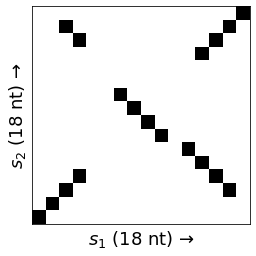

In [28]:
wotplot.viz_imshow(m)

### 1.4.3. For comparison's sake: `viz_spy()`

The default `markersize` used by `viz_spy()` is `0.5`. I set this as the default because it's useful for plots of very long sequences; however, it's less useful for plots of tiny sequences like this one.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

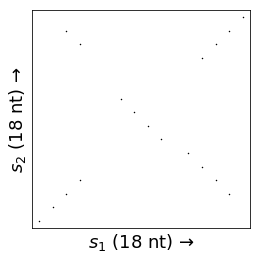

In [29]:
wotplot.viz_spy(m)

We can adjust the `markersize` when we call `viz_spy()`, which makes this visualization look essentially the same as what we'd get from `viz_imshow()`:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

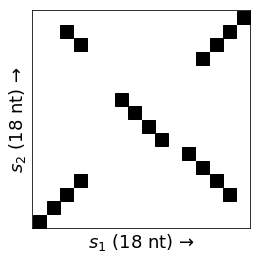

In [30]:
wotplot.viz_spy(m, markersize=13)

# 2. Distinguishing forward, reverse-complementary, and palindromic matches

If we set `binary=False` when creating a `DotPlotMatrix` object, then wotplot will distinguish between forward, reverse-complementary, and palindromic matches. This can be useful for certain analyses; also, we can color these matches differently in the visualization!

## 2.1. Using `binary=False` with the same dataset as above

In [31]:
n = wotplot.DotPlotMatrix(s1, s2, k, binary=False)

If we convert `n`'s matrix to a dense format, we see that now it doesn't just contain `0` and `1` values:

In [32]:
n.mat.toarray()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,

In this not-binary matrix:

- `1` values indicate forward matches,
- `-1` values indicate reverse-complementary matches, and
- `2` values indicate palindromic matches (there aren't any of those in this example).

For reference, these values actually correspond to constants in wotplot's package (`wotplot.FWD`, `wotplot.REV`, and `wotplot.BOTH`, respectively; for binary matrices, `1` values correspond to `wotplot.MATCH`). If you're writing code that works with these matrices, I suggest using these constants instead of `1`, `-1`, etc.; this might improve readability a bit. (But it's not a huge deal.)

Okay, now let's draw this matrix! `viz_imshow()` will automatically notice that this matrix was created using `binary=False`, and will draw it in color.

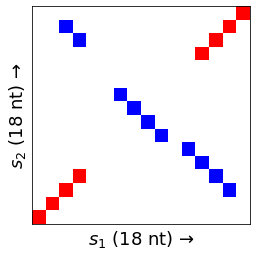

In [33]:
fig, ax = wotplot.viz_imshow(n)
# Since we include it in the README, we'l save this drawing to a file.
# We can do this using the fig object returned by viz_imshow() (or by viz_spy()).
fig.savefig(os.path.join("img", "small_example_dotplot.png"), **savefig_kwargs)

Note that `viz_spy()` can only use one color for all match cells (by default this color is set to black), so visualizing a `binary=False` matrix with `viz_spy()` doesn't look different from visualizing the equivalent `binary=True` (default) matrix:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

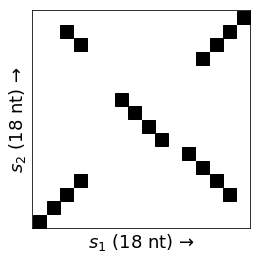

In [34]:
wotplot.viz_spy(n, markersize=13)

## 2.2. Another dataset that includes palindromes

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (21 nt) →', ylabel='$s_2$ (21 nt) →'>)

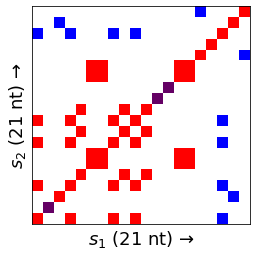

In [35]:
p = wotplot.DotPlotMatrix("AGCAGAAAGAGATAAACCTGT", "AGCAGAAAGAGATAAACCTGT", 2, binary=False)
wotplot.viz_imshow(p)

## 2.3. Adjusting the colormap used

We can adjust this with the `nbcmap` parameter of `viz_imshow()`, which is a `dict` mapping cell values (0, 1, -1, 2) to RGB triplet colors.

Here, we can use `nbcmap` to create "dark mode" dot plots:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (21 nt) →', ylabel='$s_2$ (21 nt) →'>)

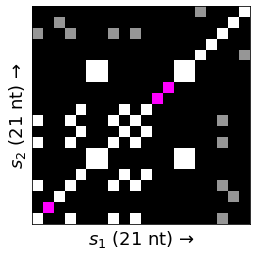

In [36]:
# it's gamer time
dark_mode_cmap = {0: [0, 0, 0], 1: [255, 255, 255], -1: [150, 150, 150], 2: [255, 0, 255]}
wotplot.viz_imshow(p, nbcmap=dark_mode_cmap)

# 3. Other fancy visualization options

## 3.1. Tiling multiple dot plots

One of the main reasons I wrote this library was so that I could create figures containing grids of many dot plots using matplotlib. wotplot makes this process fairly painless!

Here's an example of creating a single figure containing two side-by-side dot plots. For our second dot plot we'll reuse the original dataset from above but, this time, set `yorder="TB"` -- this will have the effect of "flipping" the y-axis so that the second sequence begins at the top and ends at the bottom of the plot. This is analogous to how [Gepard](https://academic.oup.com/bioinformatics/article/23/8/1026/198110)'s dot plots look.

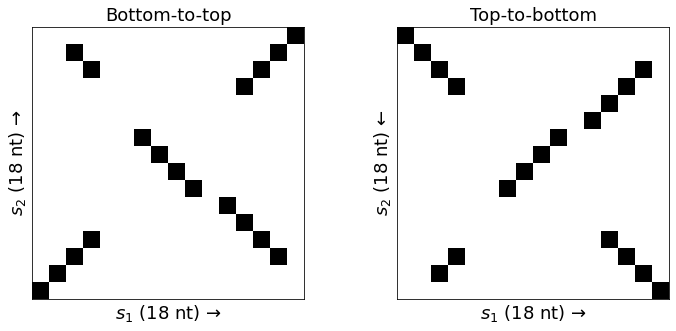

In [37]:
# Second dot plot: same as the original, but different y-order
m_flipped = wotplot.DotPlotMatrix(s1, s2, k, yorder="TB")

fig, (axLeft, axRight) = pyplot.subplots(1, 2)

# Notice how we provide an argument to the ax parameters of these functions.
# This way, we can create these Axes objects in advance (when we call
# pyplot.subplots()).
wotplot.viz_imshow(m, ax=axLeft)
wotplot.viz_imshow(m_flipped, ax=axRight)

axLeft.set_title('Bottom-to-top', fontsize=18)
axRight.set_title('Top-to-bottom', fontsize=18)
fig.set_size_inches(12, 5)

## 3.2. Passing arbitrary keyword arguments to `imshow()` / `spy()`

These functions have a lot of options available (see the matplotlib docs for [`imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) and [`spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.spy.html)), and we can make use of these options without too much effort:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

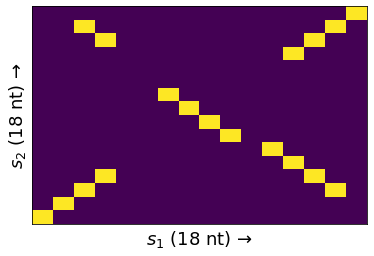

In [38]:
# - Set cmap to "viridis" (by default, viz_imshow() sets cmap to "gray_r" for binary matrices, but we can
#   override this here).
# - Set aspect to "auto", which lets cells be non-square (their dimensions will adjust as we resize the plot).
wotplot.viz_imshow(m, cmap="viridis", aspect="auto")

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

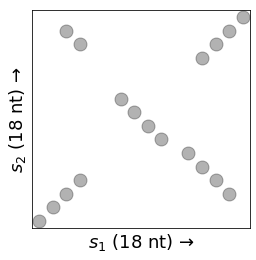

In [39]:
# - Set marker to "o" (draw circles instead of squares for matching cells).
# - Set alpha to 0.3 (add some transparency to the matching cells).
wotplot.viz_spy(m, markersize=13, marker="o", alpha=0.3)

## 3.3. Adding ticks, tick labels, and a grid
We'll show this by reusing the above example.

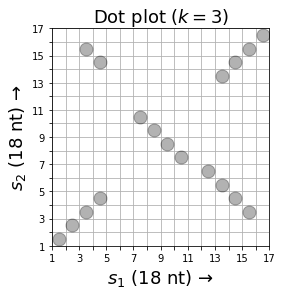

In [109]:
# While we're adding this other explanatory stuff, let's add a title for good measure.
fig, ax = wotplot.viz_spy(m, markersize=13, marker="o", alpha=0.3, title=f"Dot plot ($k = {m.k}$)")

### PART 1: TICKS
# First, let's add ticks.
#
# Our ticks' positions will look like [-0.5, 0.5, 1.5, ..., 13.5, 14.5, 15.5]. We
# create them in this way because the cells of the matrix occur at integer coordinates.
# (You could draw ticks at [0, 1, 2, ...], if you'd prefer, but then the grid lines would
# go through the middle of the dot plot's points. I think the [-0.5, 0.5, ...] way looks nicer.)
ticks = [t - 0.5 for t in range(0, 17)]

# The x-axis is simple -- just use these ticks.
ax.set_xticks(ticks)

# The y-axis is a bit more complicated. Keep in mind that, when creating "m" above, we left
# the DotPlotMatrix "yorder" parameter at its default of "BT" -- so the y-axis goes from bottom
# to top. However, matplotlib doesn't care about this -- by default, it'll order ticks from top
# to bottom (since it considers "row 0" to be the topmost row in the matrix, then row 1, ...)
# We can address this by reversing the ticks when we provide them to matplotlib.
ax.set_yticks(ticks[::-1])

### PART 2: TICK LABELS
# Next, let's add tick labels. Adding one label for every tick is a bit excessive,
# so let's just add labels for every other tick. (For dot plots of long sequences,
# you'd probably want to add ticks and tick labels a lot farther apart -- e.g.
# separated by 1 Mbp.)
tick_labels = []
# Even though Python uses 0-indexing, we'll use 1-indexing here to make this plot a bit easier
# to interpret -- so we'll use range(1, 18) instead of range(0, 17).
for i in range(1, 18):
    if i % 2 == 1:
        # Only add labels for odd-numbered positions.
        tick_labels.append(f"{i:,}")
    else:
        # We still need to add something for the even-numbered positions (to match the
        # number of ticks we added above), so we'll add an empty string for each of these ticks.
        tick_labels.append("")

# Since we already reversed the ticks for the y-axis to account for how yorder="BT", we can now
# provide the tick labels for both the x- and y-axes in ascending order.
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

ax.tick_params(
    labeltop=False, labelbottom=True, labelleft=True, labelright=False,
    top=False, bottom=True, left=True, right=False
)

### PART 3: GRID LINES
# This part is easy :)
# (Note that ax.grid() has a lot of options you can play around with [linestyle, color, ...])
ax.grid()

# 4. Creating dot plots of longer sequences

As a final example, let's create a dot plot of two _E. coli_ strains' genomes. We'll use _E. coli_ K-12 [(from this assembly)](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000005845.2/) and _E. coli_ O157:H7 [(from this assembly)](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000008865.2/).

I haven't included these FASTA files in the repository because they're both fairly large (both around ~5 MB), but -- for reference -- I downloaded them from the NCBI's website, moved them to a folder in this repository named `docs/data/`, and removed the two plasmid sequences from the O157:H7 assembly. (The K-12 assembly doesn't include any plasmid sequences; I guess this makes sense, given [the history of the K-12 strain](https://en.wikipedia.org/wiki/Escherichia_coli_in_molecular_biology#K-12)?)

In [21]:
# Note that pyfaidx (https://github.com/mdshw5/pyfaidx), the library I use here to
# load these FASTA files' sequences into memory, isn't included as a dependency of
# wotplot; you can load your sequences however you'd like.
import pyfaidx
e1 = pyfaidx.Fasta(os.path.join("data", "ecoli_k12.fna"))
e2 = pyfaidx.Fasta(os.path.join("data", "ecoli_o157h7.fna"))

In [22]:
# Extract the sequences from these pyfaidx.Fasta objects. (Both only contain
# one sequence / "record", hence the "list(e1.records)[0]" operations -- it's
# a way of saying "give me the name of the only sequence in this FASTA file.")
e1s = str(e1[list(e1.records)[0]])
e2s = str(e2[list(e2.records)[0]])

#### Sidenote: how do I select the $k$-mer size when dealing with big sequences?
I don't have a single perfect answer. In general: smaller values of $k$ will show more details, but they'll increase the number of random matches between the two sequences, which will in turn increase the density of the dot plot matrix, which will in turn increase the memory footprint of the matrix. So you should consider the length of your sequences, their expected degree of similarity, and how much memory your system has when selecting the $k$-mer size.

If you're really curious, here are some vague, informal suggestions that might be a good starting point. For tiny sequences (e.g. < 100 bp), any $k$ should be ok. For small-ish sequences (e.g. 100 bp – 1 kbp), any $k > 2$ should be ok. For sequences in the range 1–100 kbp, I tend to use $k = 10$. For large sequences (e.g. > 100 kbp), I recommend using $k > 10$. (But none of this is written in stone, so please don't quote me on it...)

#### Sidenote: I didn't read that sidenote and you're bad at writing documentation
Wow, that's kind of harsh??? But don't worry, you didn't miss much. Let's create the matrix now; we'll use a $k$-mer size of $k$ = 20. We'll also set `verbose=True` in order to get detailed logging output as the matrix is constructed -- this helps reassure us that wotplot isn't frozen.

In [23]:
em = wotplot.DotPlotMatrix(e1s, e2s, 20, verbose=True)

0.00s: validating inputs...
0.47s: computing suffix array for s1...
0.87s: computing suffix array for s2...
1.41s: computing ReverseComplement(s2)...
2.28s: computing suffix array for ReverseComplement(s2)...
2.72s: finding forward matches between s1 and s2...
97.00s: found 3,357,713 forward match cell(s).
97.00s: finding matches between s1 and ReverseComplement(s2)...
181.05s: found 3,536,693 total match cell(s).
181.05s: density = 0.00%.
181.05s: converting match information to COO format inputs...
183.15s: creating sparse matrix from COO format inputs...
184.32s: done creating the matrix.


Creating the matrix took about 3 minutes and 4 seconds (on my five-year old laptop with 8 GB of RAM). All things considered, not too shabby!

Now let's visualize the matrix. We pretty much have to use `viz_spy()` here -- using `viz_implot()` is not feasible, because creating a dense-format copy of this matrix would require us to have... wait, how many cells were in that matrix?

In [24]:
f"{em.mat.shape[0] * em.mat.shape[1]:,} cells."

'25,522,292,906,847 cells.'

Okay, so if we make the optimistic assumption that each cell in the matrix can be stored in a single bit (I don't think this is true), then we'd still need ~3.19 terabytes (!!!) of memory to store the matrix in dense format. That's not happening on my laptop, so we'll have to use `viz_spy()`.

In [25]:
em.mat.shape

(5498559, 4641633)

NameError: name 'em' is not defined

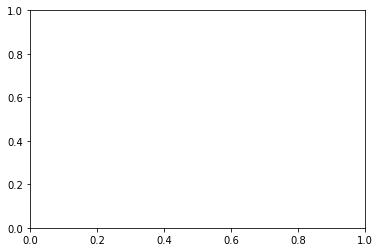

In [111]:
fig, ax = pyplot.subplots()
wotplot.viz_spy(em, markersize=0.01, title=f"Comparison of two $E. coli$ genomes ($k$ = {em.k})", ax=ax)
ax.set_xlabel(f"$E. coli$ K-12 substr. MG1655 ({len(e1s)/1e6:.2f} Mbp) \u2192")
ax.set_ylabel(f"$E. coli$ O157:H7 str. Sakai ({len(e2s)/1e6:.2f} Mbp) \u2192")
fig.set_size_inches(8, 8)
fig.savefig(os.path.join("img", "ecoli_example_dotplot.png"), **savefig_kwargs)

There we have it! You may want to play around with the `markersize` parameter a bit in order to see what looks best.